### LeNet-5

LeNet-5 is a classic CNN architecture published by Yann LeCun et al. early in 1998. It is elegant and simple, and achieves good performance on a relatively small dataset such as MNIST. Here, we use this architecture as the first example for learning how to implement and train neural networks. We will start with using <code>tensorflow.keras</code>, which is one of the high-level APIs in TensorFlow. 

The architecture of LeNet-5 is as follows:
<img src="./files/LeNet-5.png">

There are three types of layers involved: the 2D convolutional layer, the max pooling layer, and the fully connected (dense) layer. These are some of the most commonly used layers in neural networks. We will look into how to build them and connect them together.

In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

1.12.0
2.1.6-tf


### Building a sequential model with <code>tf.keras</code>
In Keras, the simplest way to build a model is to use <code>tf.keras.Sequential</code>, which specifies a stack of layers. To add layers, just call the <code>add</code> method. Each layer will take the output of the previous layer as input. As an example, now we create a sequential model and add the first convolutional layer C1. C1 uses 5 by 5 convolutions with stride 1. It does not add paddings to the sides of the input, so the size of both dimensions of each feature map will be reduced by 4 after the convolution. Layers in Keras are available in <code>tf.keras.layers</code>. Here, we will be using <code>tf.keras.layers.Conv2D</code>. There are a bunch of arguments by which you can specify the parameters of the layer, but the most import ones are:

<code>filters</code>: the number of feature maps produced as output. Here it will be 6.

<code>kernel_size</code>: the size of the convolution kernel/filter specified as (height, width). Here it will be (5, 5) or simply 5.

<code>strides</code>: strides of moving the convolution kernel/filter along the height and width axes. Here will be (1, 1) or simply 1.

<code>padding</code>: can be <code>"valid"</code> or <code>"same"</code>. <code>"valid"</code> will not add paddings to the input, but will drop the last convolution if the kernel goes over the edge of the input. <code>"same"</code> will try to add the same amount of paddings to the two sides of each dimension, but if the number of rows/columns to be added is odd, the right/bottom side will have one more padding than the other side. Here we are going to use <code>"valid"</code>.

<code>activation</code>: the activation function to use. After element-wise multiplication between the kernel and regions of the input and summation, we need to transform the sum to a value between 0 and 1. Activation functions are availble in <code>tf.keras.activations</code>, and here we're going to use the tanh function.

<code>input_shape</code>: when the layer is used as the first layer, we need to provide the shape of the input. Input shape should be provided as a tuple of (height, width, channels). The convolution will be applied to the first two dimensions, i.e. height and width, while the last dimension will maintain the number of feature maps. For grayscale input, there is only one input channel, while input in the RGB format, there are three input channels. Here, the shape of the input will be (32, 32, 1).

There are additional variables by which you can specify how to initialize, regularize or constrain the variables of the layer, but those mentioned above are the most important ones, and we will specify them when building the first layer, C1.

In [2]:
# Create a sequential model.
model = keras.Sequential()

# Add the first layer, C1, to the sequential model.
model.add(keras.layers.Conv2D(filters=6, 
                              kernel_size=(5,5), 
                              strides=(1,1), 
                              padding="valid", 
                              activation=keras.activations.tanh))

Great! Now we have our first layer in place. The second layer, S2, will be a 2D max pooling layer. This is implemented through <code>tf.keras.layers.MaxPool2D</code>. Here we also have a few arguments that need specification:

<code>pool_size</code>: the size of the pooling kernel/filter. Here it will be (2,2) or simply 2.

<code>strides</code>: the strides by which to move the pooling kernel/filter. If this is not specified it will default to <code>pool_size</code>, which essentially means that the pooling kernels will not be overlapping. Here we can leave it unspecified or use (2,2).

<code>padding</code>: can be <code>"valid"</code> or <code>"same"</code>. Same meaning as in the convolutional layer. Here it will be equivalent to use either one.

In [3]:
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), 
                                    strides=(2,2), 
                                    padding="valid"))

Using the same syntax, we can go on and add one more convolutional layer, C3, and one more pooling layer, S4. Note that for C3 we do not need to specify <code>input_shape</code> anymore because it will be inferred from the output of the previous layer.

In [4]:
model.add(keras.layers.Conv2D(filters=16, 
                              kernel_size=(5,5), 
                              strides=(1,1), 
                              padding="valid", 
                              activation=keras.activations.tanh))

model.add(keras.layers.MaxPooling2D(pool_size=(2,2), 
                                    strides=(2,2), 
                                    padding="valid"))

The next layer we are going to add, F5, is a fully-connected layer of 120 neurons. However, let's look back and examine the shape of the output from layer S4. For each picture passing through S4, the output will be a 3D tensor of (5, 5, 16). Before building the fully connected layer, we need to reshape this 3D tensor into a 1D tensor. This is done by adding a <code>tf.keras.layers.Flatten</code> layer.

After that, we can go ahead and add a fully-connected layer using <code>tf.keras.layers.Dense</code>. Similar to other layers, there are some arguments to specify:

<code>units</code>: the number of neurons in the layer.

<code>activation</code>: the activation function to use. If not specified it will just be a linear transformation.

So now we can go ahead and add dense layers F5 and F6 to our model.

In [5]:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=120, 
                             activation=keras.activations.tanh))

model.add(keras.layers.Dense(units=84, 
                             activation=keras.activations.tanh))

Now comes the time to build the output layer. Since this is a multiclass classification problem with 10 classes, the output layer will just be a dense layer consisting of 10 neurons. However, instead of using tanh as the activation function, we use the softmax function to convert the 10 numbers into a probability distribution. 

In [6]:
model.add(keras.layers.Dense(units=10, 
                             activation=keras.activations.softmax))

Cool! We have finished building our model! However, the model architecture itself is not enough for training a neural network. We also need to specify what loss function we want to optimize and what algorithm we want to use to optimize the loss function. These need to be done through calling the <code>compile</code> method of the model. This method has a few import arguments:

<code>loss</code>: loss function to optimize. For multiclass classification, we usually use categorical cross entropy. Note that the loss function to use is dependent on the encoding of the class labels in our data. If they are encoded in a one-hot fashion, then we should use <code>"categorical_crossentropy"</code>. However, in our case where the labels are encoded with a set of numbers, we should use <code>"sparse_categorical_crossentropy"</code>. 

<code>optimizer</code>: optimization algorithm to use. Here we will use the classic algorithm, stochastic gradient descent. Optimizers are availble in <code>tf.keras.optimizers</code>. Learning rate should be passed to the constructor of the optimizer. 

<code>metrics</code>: list of metrics to be evaluated by the model. For example, we can calculate classification accuracy. For this we just have to contain the string <code>"accuracy"</code> in the list.

In [7]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(), 
              metrics=["accuracy"])

### Preparing input data

Now that we have specified (almost) everything for the model, let's look at how to load and prepare a dataset for training. Let's use the MNIST dataset as an example. <code>tf.keras</code> contains a number of datasets itself in <code>tf.keras.datasets</code>, so we don't have to download the data by ourselves. Each dataset there already contains a training set and a test set. To load MNIST, we can do the following:

In [8]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Since the test set cannot be used for hyperparameter optimization, we should have a development set where we can evaluate the performance of our model and adjust hyperparameters. Cross-validation is usually not performed for neural networks due to the prohibitively long time needed for training. Therefore, we randomly select 10,000 images from the training set as the development set, while the remaining 50,000 will be used for training.

In [9]:
import random
import numpy as np

dev_indices = np.array(random.sample(range(train_labels.shape[0]), 10000))
dev_images = train_images[dev_indices]
dev_labels = train_labels[dev_indices]
train_images = np.delete(train_images, dev_indices, axis=0)
train_labels = np.delete(train_labels, dev_indices, axis=0)

print(train_images.shape, train_labels.shape)
print(dev_images.shape, dev_labels.shape)

(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)


Since the value of each pixel ranges from 0 to 255, we can apply normalization to get everything between 0 and 1.

In [10]:
train_images = train_images.astype(np.float32) / 255.0
dev_images = dev_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

Now let's visualize some of the images.

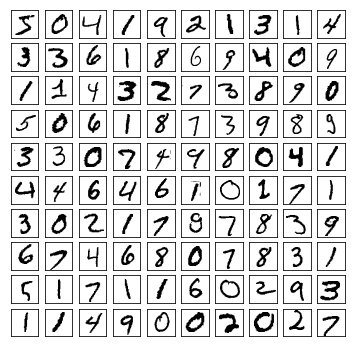

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(10,10)
fig.set_figwidth(6)
fig.set_figheight(6)
for i in range(100):
    ax[i//10][i%10].imshow(train_images[i], cmap=plt.cm.binary)
    ax[i//10][i%10].set_xticks([])
    ax[i//10][i%10].set_yticks([])

We're almost ready to train the network! The last thing we need to do is to reshape the input so that it conforms to the input size specified by our model. In our case, we just need to add one more dimension, which is the channel size. 

In [12]:
train_images = train_images.reshape(50000, 28, 28, 1)
dev_images = dev_images.reshape(10000, 28, 28, 1)
test_images = test_images.reshape(10000, 28, 28, 1)

### Training and testing the neural network

Training a model in Keras is a breeze. Just call the <code>fit</code> method of the model and specify some training setups:

<code>x</code>: input data. Here this will be <code>train_images</code>.

<code>y</code>: target data. Here this will be <code>train_labels</code>.

<code>batch_size</code>: how many training instances to feed into the neural network in each step. This defaults to 32, but we will use a larger batch of 128.

<code>epochs</code>: the number of epochs for which we want to train the model. An epoch means that we go through the entire training set once, which usually involve multiple steps because in each step we only feed in <code>batch_size</code> number of training instances.

<code>validation_split</code>: the fraction of data to be used for validation. This portion of data will not be trained on, but will be evaluated on at the end of each epoch. This fulfills essentially the same function as our development set.

<code>validation_data</code>: a tuple of <code>(x_val, y_val)</code> specifying the data for validation at the end of each epoch. Here we'll pass our development set to this argument.

<code>initial_epoch</code>: If the model has been trained for a number of epochs and we want to continue training it, we can pass the epoch number here.

This method will return a <code>tf.keras.callbacks.History</code> instance

In [13]:
history = model.fit(x=train_images, 
                    y=train_labels, 
                    batch_size=128, 
                    epochs=20, 
                    validation_data=(dev_images, dev_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 147us/step - loss: 1.3072 - acc: 0.6845 - val_loss: 0.6176 - val_acc: 0.8672
Epoch 2/20
50000/50000 [==============================] - 3s 50us/step - loss: 0.4801 - acc: 0.8859 - val_loss: 0.3768 - val_acc: 0.9087
Epoch 3/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.3382 - acc: 0.9127 - val_loss: 0.2943 - val_acc: 0.9252
Epoch 4/20
50000/50000 [==============================] - 2s 47us/step - loss: 0.2744 - acc: 0.9270 - val_loss: 0.2482 - val_acc: 0.9335
Epoch 5/20
50000/50000 [==============================] - 2s 45us/step - loss: 0.2347 - acc: 0.9359 - val_loss: 0.2182 - val_acc: 0.9391
Epoch 6/20
50000/50000 [==============================] - 2s 48us/step - loss: 0.2066 - acc: 0.9427 - val_loss: 0.1957 - val_acc: 0.9463
Epoch 7/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.1852 - acc: 0.9480 - val_loss: 0.1778 - val_ac

To obtain the training accuracy and validation accuracy, just take them from the returned history variable.

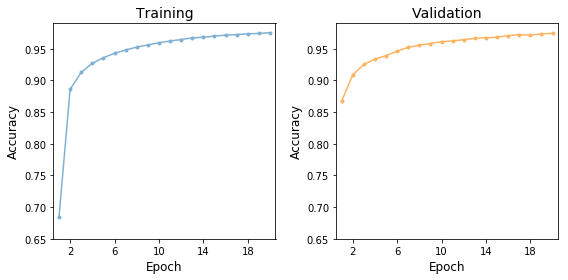

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(8)

ax1.plot(history.history['acc'], color='#80b1d3', marker='.')
ax2.plot(history.history['val_acc'], color='#fdb462', marker='.')
ax1.set_title("Training", size=14)
ax2.set_title("Validation", size=14)

for ax in [ax1, ax2]:
    ax.set_xlim(-0.5, 19.5)
    ax.set_ylim(0.65, 0.99)
    ax.set_xticks([1, 5, 9, 13, 17])
    ax.set_xticklabels([int(x+1) for x in ax.get_xticks()])
    ax.set_xlabel("Epoch", size=12)
    ax.set_ylabel("Accuracy", size=12)
fig.tight_layout()

Suppose we're satisfied with our model and we want to test it on the test set. We can simply call the <code>evaluate</code> method of the model. 

In [15]:
loss, acc = model.evaluate(x=test_images, y=test_labels)
print("Test set accuracy: %.4f" % acc)

10000/10000 [==============================] - 1s 82us/step
Test set accuracy: 0.9759


And finally, calling the <code>summary</code> method should give you some summary statistics of the model, such as the total number of trainable parameters.

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  30840     
_________________________________________________________________
dense_1 (Dense)              multiple                  10164     
__________

That's it for our first neural network! You can try to adjust some hyperparameters or the model architecture and see if you can get better performance!